In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import pygsheets
import dataframe_image as dfi
from datetime import date
from PIL import Image   
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import PoissonRegressor                                                                             
import re
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

In [2]:
#Defino modelo
import urllib.request
import numpy as np
# Lists to score training data
X = []
y = []

# Iterate through each World Cup from 1990 - 2018
for year in ['1990', '1994', '1998', '2002', '2006', '2010', '2014', '2018']:

    # Download file using urllib
    urllib.request.urlretrieve(f"https://github.com/norrisjamie23/WorldCup2022Forecasting/raw/main/data/{year}.csv", f"{year}.csv")
    
    # Open file containing data from WC
    data = np.loadtxt(f"{year}.csv", delimiter=',', dtype=str, usecols=0, encoding='UTF-8')
    data = np.char.replace(data, '−', '-')

    # Get ELO ratings of "home" and "away" teams from each game in WC
    home_elo = data[10::16].astype(int) - data[8::16].astype(int)
    away_elo = data[11::16].astype(int) - data[9::16].astype(int)

    # Get score for each team
    home_score = data[4::16].astype(int)
    away_score = data[5::16].astype(int)

    # Add these to our lists
    X.append(np.stack((home_elo, away_elo), axis=-1))
    y.append(np.stack((home_score, away_score), axis=-1))

# Concatenate into a NumPy array
X = np.concatenate(X)
y = np.concatenate(y)

# Split data into training and testing partitions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=2022
)

# No home advantage in the World Cup (mostly!), so duplicate the dataset
X_train = np.concatenate((X_train, X_train[:, ::-1]), axis=0)
y_train = np.concatenate((y_train, y_train[:, ::-1]), axis=0)

model = MultiOutputRegressor(
    PoissonRegressor(fit_intercept=True)
)

# Fit our PoissonRegressor
model.fit(X_train, y_train)

# See the predicted deviance explained on the test set
model.score(X_test, y_test)

-0.22831328140576668

In [5]:
#Agarro ELO Ratings del futbol argento
options = Options()
driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
driver.get('http://degolazos.com/ranking-argentina/')
html = driver.page_source
driver.close()

#Lo hago dataframe y despues diccionario.
df = pd.read_html(html)[1]
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
lista_elo_ratings = df[['EQUIPO', 'Puntos']].set_index('EQUIPO').to_dict()['Puntos']
lista_elo_ratings



====== WebDriver manager ======
Current google-chrome version is 109.0.5414
Get LATEST driver version for 109.0.5414
Driver [C:\Users\Federico Rábanos\.wdm\drivers\chromedriver\win32\109.0.5414.74\chromedriver.exe] found in cache


{'River Plate': '1623',
 'Boca Juniors': '1590',
 'Racing Club': '1578',
 'Vélez Sarsfield': '1561',
 'Huracán': '1554',
 'San Lorenzo': '1502',
 'Tigre': '1496',
 'Talleres': '1495',
 'Argentinos Juniors': '1491',
 "Newell's Old Boys": '1481',
 'Defensa y Justicia': '1472',
 'Gimnasia y Esgrima': '1472',
 'Estudiantes': '1469',
 'Independiente': '1459',
 'Atlético Tucumán': '1448',
 'Patronato': '1441',
 'Rosario Central': '1438',
 'Arsenal': '1418',
 'Central Córdoba': '1404',
 'Unión': '1392',
 'Barracas Central': '1391',
 'Sarmiento': '1388',
 'Colón': '1374',
 'Godoy Cruz': '1368',
 'Banfield': '1365',
 'Platense': '1363',
 'Lanús': '1341',
 'Aldosivi': '1249'}

In [3]:
#Estos son los ELOs antes de que arranque el torneo
lista_elo_ratings = {'1': {
    'River Plate': '1623',
 'Boca Juniors': '1590',
 'Racing Club': '1578',
 'Vélez Sarsfield': '1561',
 'Huracán': '1554',
 'San Lorenzo': '1502',
 'Tigre': '1496',
 'Talleres': '1495',
 'Argentinos Juniors': '1491',
 "Newell's Old Boys": '1481',
 'Defensa y Justicia': '1472',
 'Gimnasia y Esgrima': '1472',
 'Estudiantes': '1469',
 'Independiente': '1459',
 'Atlético Tucumán': '1448',
 'Patronato': '1441',
 'Rosario Central': '1438',
 'Arsenal': '1418',
 'Central Córdoba': '1404',
 'Unión': '1392',
 'Barracas Central': '1391',
 'Sarmiento': '1388',
 'Colón': '1374',
 'Godoy Cruz': '1368',
 'Banfield': '1365',
 'Platense': '1363',
 'Lanús': '1341',
 'Aldosivi': '1249'}
}

In [4]:
df = pd.DataFrame.from_dict(lista_elo_ratings).reset_index().rename(columns={'index':'EQUIPO', '1': 'Puntos'})
df

In [6]:
#Agarro valoraciones de los equipos del futbol argento
options = Options()
driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
driver.get('https://www.transfermarkt.com.ar/superliga/marktwerteverein/wettbewerb/AR1N')
html = driver.page_source
driver.close()

#Los hago df y trato de limpiar un poquito la data
df_valoraciones = pd.read_html(html)[1]
df_valoraciones.rename(columns={f'{df_valoraciones.columns[5]}': 'Valor Actual'}, inplace=True)
df_valoraciones = df_valoraciones[['Club', 'Valor Actual']].iloc[:-1]
df_valoraciones['Valor Actual'] = df_valoraciones['Valor Actual'].str.strip(' mill. €').str.replace(',', '.')
df_valoraciones['Valor Actual'] = df_valoraciones['Valor Actual'].astype(float) * 1000000
df_valoraciones['Club'] = df_valoraciones['Club'].str.replace('CA ', '').str.replace('Club Atlético ', '').str.replace('Club ', '').str.replace('CSD ', '').str.replace('CD ', '').str.replace('AA ', '').str.replace(' Antonio Tomba', '')



====== WebDriver manager ======
Current google-chrome version is 109.0.5414
Get LATEST driver version for 109.0.5414
Get LATEST driver version for 109.0.5414
Trying to download new driver from https://chromedriver.storage.googleapis.com/109.0.5414.74/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\Federico Rábanos\.wdm\drivers\chromedriver\win32\109.0.5414.74]


In [7]:
#Armo arrays en base al df de elo ratings
teams, elo_scores = np.array(df['EQUIPO']), np.array(df['Puntos'])
elo_scores = elo_scores.astype(float)
#Armo arrays en base al df de valoraciones
equipos, values = np.array(df_valoraciones['Club']), np.array(df_valoraciones['Valor Actual'])
lista_values = dict(zip(equipos, values))
values = values.astype(float)

In [8]:
values

array([97650000., 85180000., 50300000., 43250000., 41850000., 38280000.,
       36880000., 32630000., 30950000., 28680000., 27050000., 26730000.,
       26630000., 23630000., 20780000., 19600000., 19530000., 17450000.,
       14180000., 13150000., 12880000., 12630000., 11800000., 10750000.,
       10250000.,  9820000.,  9030000.,  5630000.])

In [9]:
#Pondero la lista de valoraciones para que se asemeje a la de elos. Esto dejo la magia que le metio Jamie.
# See how much list of team values needs to be scaled to match std dev of elo scores
scale_std = values.std() / elo_scores.std()
# Scale it appropriately
values = values / scale_std

# Work out the difference in means
scale_mean = elo_scores.mean() - values.mean()

# Adjust mean of values
values += scale_mean

# Get values in dictionary form
values_init = dict(zip(equipos, values))

In [10]:
#Armo df con las valoraciones ponderadas
df_values_init = pd.DataFrame(list(values_init.items()))
df_values_init[0] = df_values_init[0].replace({
    'San Lorenzo de Almagro': 'San Lorenzo',
    'de Gimnasia y Esgrima La Plata': 'Gimnasia y Esgrima',
    'Sarmiento (Junín)': 'Sarmiento',
    'Central Córdoba (SdE)': 'Central Córdoba',
    'Arsenal Fútbol Club': 'Arsenal',
    'Instituto AC Córdoba': 'Instituto',
    'Tucumán': 'Atlético Tucumán',
    'Estudiantes de La Plata': 'Estudiantes'
})

#Armo el df para los elos, aca ojo con el [1] en base a si saco la info hardcodeada o desde la pagina.
df_elo_ratings = pd.DataFrame(list(lista_elo_ratings['1'].items()))
print(df_elo_ratings)
#Mergeo ambos
df_todo = df_values_init.merge(df_elo_ratings, on=0, how='outer').iloc[:-2].set_index(0)
df_todo['1_y'] = df_todo['1_y'].fillna('1300') #Aca considero a los ascendidos con ELO 1300.

#Paso el df mergeado a listas
lista_values_2 = df_todo[['1_x']].to_dict()['1_x']
lista_elo_ratings_2 = df_todo[['1_y']].to_dict()['1_y']


                     0     1
0          River Plate  1623
1         Boca Juniors  1590
2          Racing Club  1578
3      Vélez Sarsfield  1561
4              Huracán  1554
5          San Lorenzo  1502
6                Tigre  1496
7             Talleres  1495
8   Argentinos Juniors  1491
9    Newell's Old Boys  1481
10  Defensa y Justicia  1472
11  Gimnasia y Esgrima  1472
12         Estudiantes  1469
13       Independiente  1459
14    Atlético Tucumán  1448
15           Patronato  1441
16     Rosario Central  1438
17             Arsenal  1418
18     Central Córdoba  1404
19               Unión  1392
20    Barracas Central  1391
21           Sarmiento  1388
22               Colón  1374
23          Godoy Cruz  1368
24            Banfield  1365
25            Platense  1363
26               Lanús  1341
27            Aldosivi  1249


In [11]:
#Armo el valor de cada equipo en base al elo y la valoración
elo_fraction = 0.70

# Armo el combinado entre ELO y valoraciones.
for key in lista_elo_ratings_2.keys():
    print(lista_elo_ratings_2[key], lista_values_2[key], key)
    lista_elo_ratings_2[key] = elo_fraction * float(lista_elo_ratings_2[key]) + (1 - elo_fraction) * lista_values_2[key]

1623 1725.5612184791075 River Plate
1590 1676.5440112599208 Boca Juniors
1561 1539.4373402250183 Vélez Sarsfield
1578 1511.7251260393512 Racing Club
1495 1506.2219913074457 Talleres
1502 1492.1889977410867 San Lorenzo
1496 1486.6858630091813 Tigre
1341 1469.9799182873253 Lanús
1554 1463.3761566090386 Huracán
1469 1454.4532167223063 Estudiantes
1374 1448.045995570159 Colón
1472 1446.7881362028663 Defensa y Justicia
1481 1446.3950551505875 Newell's Old Boys
1491 1434.6026235822185 Argentinos Juniors
1438 1423.399813592268 Rosario Central
1365 1418.7614571753763 Banfield
1448 1418.486300438781 Atlético Tucumán
1459 1410.3102145513785 Independiente
1368 1397.4564641418565 Godoy Cruz
1392 1393.4077293033831 Unión
1472 1392.3464104622299 Gimnasia y Esgrima
1300 1391.3637078315326 Belgrano
1363 1388.101135097617 Platense
1404 1383.973784048688 Central Córdoba
1388 1382.0083787872932 Sarmiento
1300 1380.3181302624937 Instituto
1391 1377.21278994949 Barracas Central
1418 1363.848034172005 Arsen

In [12]:
#Como queda fachero fachero
dict(sorted(lista_elo_ratings_2.items(), key=lambda lista_elo_ratings_2: lista_elo_ratings_2[1], reverse=True))

{'River Plate': 1653.7683655437322,
 'Boca Juniors': 1615.9632033779762,
 'Racing Club': 1558.1175378118053,
 'Vélez Sarsfield': 1554.5312020675053,
 'Huracán': 1526.8128469827116,
 'San Lorenzo': 1499.056699322326,
 'Talleres': 1498.3665973922339,
 'Tigre': 1493.2057589027545,
 'Argentinos Juniors': 1474.0807870746657,
 "Newell's Old Boys": 1470.6185165451764,
 'Estudiantes': 1464.635965016692,
 'Defensa y Justicia': 1464.4364408608599,
 'Gimnasia y Esgrima': 1448.103923138669,
 'Independiente': 1444.3930643654135,
 'Atlético Tucumán': 1439.1458901316341,
 'Rosario Central': 1433.6199440776804,
 'Arsenal': 1401.7544102516015,
 'Central Córdoba': 1397.9921352146064,
 'Colón': 1396.2137986710477,
 'Unión': 1392.422318791015,
 'Barracas Central': 1386.863836984847,
 'Sarmiento': 1386.2025136361879,
 'Banfield': 1381.1284371526128,
 'Lanús': 1379.6939754861976,
 'Godoy Cruz': 1376.836939242557,
 'Platense': 1370.530340529285,
 'Belgrano': 1327.4091123494597,
 'Instituto': 1324.09543907874

In [25]:
#Lo paso a df para mostrarlo en Tw
df_export = pd.DataFrame.from_dict(lista_elo_ratings_2, orient='index').rename(columns={0:'ELO + Valoración'}).sort_values(ascending=False, by= 'ELO + Valoración').style.background_gradient()
df_export

,ELO + Valoración
River Plate,1653.768366
Boca Juniors,1615.963203
Racing Club,1558.117538
Vélez Sarsfield,1554.531202
Huracán,1526.812847
San Lorenzo,1499.056699
Talleres,1498.366597
Tigre,1493.205759
Argentinos Juniors,1474.080787
Newell's Old Boys,1470.618517


In [26]:
def simulate_matches(fixtures, teams_df=None, lam_multiplier=1):
    """Function to simulate matches.
    Basicamente le podes pasar una lista de fixtures (partidos a simular) 
    y un df con el elo y los equipos.
    O pasarle una lista con los elos directamente (lista fixtures)
    Modifique un toquecito la func de Jamie, pero basicamente es casi toda de él.

    Parameters
    ----------
    fixtures : list (float or str), optional
        A 2D list of fixtures, either represented as strings when team_df is
        provided, or as ELO scores if not.

    team_df : Pandas dataframe, optional
        A Pandas dataframe with "Team" and "ELO" as columns. If fixtures is in
        str form, this will be used to map it to ELO float form.

    lam_multiplier : float, optional
        How much to scale a teams lambda value by. If they're expected to score
        2.5 goals in a game, and we want to know how many they'll score in a 
        half, we can use lam_multiplier to scale the expected number of goals
        down to 1.25.

    Returns
    ------
    score : ndarray
        This is the same size as fixtures, with each element corresponding to 
        how many goals each team scored in a simulation.
    """
          
    # If no fixtures to simulate, return none
    if(len(fixtures)) == 0:
        return None
    
    # If teams_df is provided, we need to map each teams name to their ELO
    if teams_df is not None:
        # Get ELO scores for each team
        elo_scores = np.vectorize(dict(zip(teams_df.Team, teams_df.ELO)).get)(fixtures).astype(np.float32)
    else:
        # Otherwise, we already have the ELO scores for each team
        elo_scores = fixtures
    
    # Predict expected number of goals per team
    lam = model.predict(elo_scores)

    # Using expected number of goals per team, draw the number of goals per team 
    # from a Poisson distribution
    score = np.random.poisson(lam * lam_multiplier)
    
    return score

In [27]:
#Estas cosas son todas de Jamie, no tuve que tocar casi nada.
def get_Ws(results, ELOs):
    """Returns result (1 for W, 0 for L, 0.5 for D) for the team with a higher ELO
    Le tengo que pasar una lista de los resultados de los partidos y de los elos
    de los equipos

    Parameters
    ----------
    results : ndarray (int)
        A 2D array of scores.

    ELOs : ndarray (float)
        A 2D array of ELOs for the teams in results.

    Returns
    ------
    Ws : ndarray
        The result for the "strongest" team in each fixture.
    """

    # Initialise Ws array
    Ws = np.zeros(ELOs.shape[:1])
    
    # Mask for games in which "home" and "away" teams won respectively
    team1_wins = results[:, 0] > results[:, 1]
    team2_wins = results[:, 0] < results[:, 1]
    
    # Mask for games that ended in draws
    draws = results[:, 0] == results[:, 1]

    # Matches with an "away" team that is stronger
    away_better = np.argmax(ELOs, axis=-1).astype(bool)

    # As above for "home"
    home_better = np.logical_not(away_better)
    
    # If "home" team won and they had a higher ELO, W is 1
    Ws[np.logical_and(home_better, team1_wins)] = 1
    
    # If "away" team won and they had a higher ELO, W is 1
    Ws[np.logical_and(away_better, team2_wins)] = 1
    
    # For draws, W is 1. Remaining values are already 0 so no need to change
    Ws[draws] = 0.5
    
    return Ws


def get_elo_adjustments(ELOs, Ws, results):
    """Get adjustment for ELOs of each team given the final score in each game.
    el array de elos de antes, el resultado de la funcion anterior y el array
    de scores de la primera func

    Parameters
    ----------
    results : ndarray (int)
        A 2D array of scores.

    ELOs : ndarray (float)
        A 2D array of ELOs for the teams in results.

    Ws : ndarray (float)
        A 1D array of results for the "strongest" team in each fixture.

    Returns
    ------
    ELO_changes_arr : ndarray
        Of the same shape as results, this says how much to adjust the ELO by.
        Each element corresponds to the same team in ELOs/results.
    """

    # Get difference in ELOs for each fixture
    drs = np.abs(ELOs[:, 0] - ELOs[:, 1])
    
    # Get probability of higher ELO team winning
    Ws_e = 1 / (10**(-drs/400) + 1)
    
    # Work out weight constant
    Ks = np.ones(ELOs.shape[0]) * 60
    
    score_diffs = np.abs(results[:, 0] - results[:, 1])
    Ks[np.where(score_diffs == 2)] *= 1.5
    Ks[np.where(score_diffs > 2)] *= 1 + (3/4 + (score_diffs[score_diffs > 2]-3)/8)
    
    # How much will ELOs change?
    ELO_changes = Ks * (Ws - Ws_e)
    
    # Put this into array showing changes for each team
    ELO_changes_arr = np.zeros((ELOs.shape[0], 2))
    ELO_changes_arr[np.arange(ELOs.shape[0]), np.argmax(ELOs, axis=1)] = ELO_changes
    ELO_changes_arr[np.arange(ELOs.shape[0]), 1 - np.argmax(ELOs, axis=1)] = -ELO_changes
        
    return ELO_changes_arr

Hasta aca flama todo, tengo las funciones de simular y ajustar el ELO despues de cada resultado

Tengo el valor de ELO * Valoración de cada equipo previo al torneo, solo me falta simular todo.

In [137]:
#Saco el fixture entero del torneo en base a Wikipedia
ultima_fecha = 2 #Por favor aca pongan la fecha que se jugo anterior a que tiran la función así Wikipedia y el scraper entienden que abrir. La últ fecha ya va a estar abierta en la pagina.
options = Options()
driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
driver.get('https://es.wikipedia.org/wiki/Campeonato_de_Primera_Divisi%C3%B3n_2023_(Argentina)')
for i in range(0,27):
    if i-1 == ultima_fecha:
        continue
    else:
        driver.find_element_by_id(f"collapseButton{i}").click()
html_wiki = driver.page_source

driver.close()



====== WebDriver manager ======
Current google-chrome version is 109.0.5414
Get LATEST driver version for 109.0.5414
Driver [C:\Users\Federico Rábanos\.wdm\drivers\chromedriver\win32\109.0.5414.74\chromedriver.exe] found in cache


In [140]:
#Ejemplo de la primera fecha como aparece en Wiki
pd.read_html(html_wiki)[11]

[ocultar]Fecha 1                                     \
                    Local Resultado                Visitante   
0         Rosario Central     1 - 0       Argentinos Juniors   
1      Defensa y Justicia     2 - 4                  Huracán   
2             San Lorenzo     1 - 0                  Arsenal   
3        Estudiantes (LP)     1 - 2                    Tigre   
4            Talleres (C)     0 - 1            Independiente   
5   Central Córdoba (SdE)     0 - 2              River Plate   
6                Platense     2 - 2        Newell's Old Boys   
7             Racing Club     0 - 0                 Belgrano   
8                   Colón     1 - 2                    Lanús   
9               Instituto     0 - 0            Sarmiento (J)   
10           Boca Juniors     1 - 0         Atlético Tucumán   
11       Barracas Central     0 - 1               Godoy Cruz   
12               Banfield     0 - 0                    Unión   
13        Vélez Sarsfield     3 - 1  Gimnasia y Esgrima (LP)   

                                                    
                       Estadio        Fecha   Hora  
0          Gigante de Arroyito  27 de enero  19:15  
1          Norberto Tomaghello  27 de enero  21:30  
2              Nuevo Gasómetro  28 de enero  17:00  
3       UNO-Jorge Luis Hirschi  28 de enero  19:15  
4         Mario Alberto Kempes  28 de enero  19:15  
5      Único Madre de Ciudades  28 de enero  21:30  
6      Ciudad de Vicente López  29 de enero  17:00  
7                  El Cilindro  29 de enero  19:15  
8   Brigadier Estanislao López  29 de enero  19:15  
9           Juan Domingo Perón  29 de enero  19:15  
10                La Bombonera  29 de enero  21:30  
11        Claudio Chiqui Tapia  30 de enero  17:00  
12              Florencio Sola  30 de enero  20:00  
13             José Amalfitani  30 de enero  20:00

In [142]:
#Uso lo que me sirve y le agrego una col de fechas para diferenciar.

#Armo el df_torneo en base al html de Wikipedia.
df_torneo = pd.DataFrame()
for i in range(0,27):
    df_1 = pd.read_html(html_wiki)[11+i][f'[ocultar]Fecha {i+1}'][['Local', 'Visitante']]
    df_1['Fecha'] = f"Fecha {i+1}"
    df_torneo = df_torneo.append(df_1)
    print(df_torneo['Fecha'])

0     Fecha 1
1     Fecha 1
2     Fecha 1
3     Fecha 1
4     Fecha 1
5     Fecha 1
6     Fecha 1
7     Fecha 1
8     Fecha 1
9     Fecha 1
10    Fecha 1
11    Fecha 1
12    Fecha 1
13    Fecha 1
Name: Fecha, dtype: object
0     Fecha 1
1     Fecha 1
2     Fecha 1
3     Fecha 1
4     Fecha 1
5     Fecha 1
6     Fecha 1
7     Fecha 1
8     Fecha 1
9     Fecha 1
10    Fecha 1
11    Fecha 1
12    Fecha 1
13    Fecha 1
0     Fecha 2
1     Fecha 2
2     Fecha 2
3     Fecha 2
4     Fecha 2
5     Fecha 2
6     Fecha 2
7     Fecha 2
8     Fecha 2
9     Fecha 2
10    Fecha 2
11    Fecha 2
12    Fecha 2
13    Fecha 2
Name: Fecha, dtype: object
0     Fecha 1
1     Fecha 1
2     Fecha 1
3     Fecha 1
4     Fecha 1
5     Fecha 1
6     Fecha 1
7     Fecha 1
8     Fecha 1
9     Fecha 1
10    Fecha 1
11    Fecha 1
12    Fecha 1
13    Fecha 1
0     Fecha 2
1     Fecha 2
2     Fecha 2
3     Fecha 2
4     Fecha 2
5     Fecha 2
6     Fecha 2
7     Fecha 2
8     Fecha 2
9     Fecha 2
10    Fecha 2
11    Fe

In [144]:
#Hago que los nombres sean consistentes.
df_torneo = df_torneo.replace({
    'Def y Justicia': 'Defensa y Justicia',
    'Estudiantes (LP)': 'Estudiantes',
    'Talleres (C)': 'Talleres',
    'Central Córdoba (SdE)': 'Central Córdoba',
    'Velez': 'Vélez Sarsfield',
    'Colon': 'Colón',
    'Gimnasia y Esgrima (LP)': 'Gimnasia y Esgrima',
    'Argentinos': 'Argentinos Juniors',
    'Newells': "Newell's Old Boys",
    'Huracan': 'Huracán',
    'Sarmiento (J)': 'Sarmiento',
    'Lanus': 'Lanús',
    'Atl Tucuman':'Atlético Tucumán',
    'Union':'Unión'
})

In [145]:
lista_elo_ratings_2

{'River Plate': 1653.7683655437322,
 'Boca Juniors': 1615.9632033779762,
 'Vélez Sarsfield': 1554.5312020675053,
 'Racing Club': 1558.1175378118053,
 'Talleres': 1498.3665973922339,
 'San Lorenzo': 1499.056699322326,
 'Tigre': 1493.2057589027545,
 'Lanús': 1379.6939754861976,
 'Huracán': 1526.8128469827116,
 'Estudiantes': 1464.635965016692,
 'Colón': 1396.2137986710477,
 'Defensa y Justicia': 1464.4364408608599,
 "Newell's Old Boys": 1470.6185165451764,
 'Argentinos Juniors': 1474.0807870746657,
 'Rosario Central': 1433.6199440776804,
 'Banfield': 1381.1284371526128,
 'Atlético Tucumán': 1439.1458901316341,
 'Independiente': 1444.3930643654135,
 'Godoy Cruz': 1376.836939242557,
 'Unión': 1392.422318791015,
 'Gimnasia y Esgrima': 1448.103923138669,
 'Belgrano': 1327.4091123494597,
 'Platense': 1370.530340529285,
 'Central Córdoba': 1397.9921352146064,
 'Sarmiento': 1386.2025136361879,
 'Instituto': 1324.095439078748,
 'Barracas Central': 1386.863836984847,
 'Arsenal': 1401.754410251601

In [146]:
#Ya tengo todo, armo la simulación para la primera fecha
fecha1 = df_torneo[df_torneo['Fecha'] == 'Fecha 1']
np.array(fecha1[['Local', 'Visitante']])

array([['Rosario Central', 'Argentinos Juniors'],
       ['Defensa y Justicia', 'Huracán'],
       ['San Lorenzo', 'Arsenal'],
       ['Estudiantes', 'Tigre'],
       ['Talleres', 'Independiente'],
       ['Central Córdoba', 'River Plate'],
       ['Platense', "Newell's Old Boys"],
       ['Racing Club', 'Belgrano'],
       ['Colón', 'Lanús'],
       ['Instituto', 'Sarmiento'],
       ['Boca Juniors', 'Atlético Tucumán'],
       ['Barracas Central', 'Godoy Cruz'],
       ['Banfield', 'Unión'],
       ['Vélez Sarsfield', 'Gimnasia y Esgrima']], dtype=object)

In [147]:
#Armo array de equipòs, clave que los nombres sean consistentes.
equipos = np.array(list(lista_elo_ratings_2.keys()))

In [148]:
#armo array de fixtures
fixtures = np.array(fecha1[['Local', 'Visitante']])

In [149]:
def simular_1fecha(all_groups_df, fixtures):
    """Esta función si que la cambie bastante.
    Simula los partidos de los fixtures que le pases (arriba defini arrays de fixtures)
    Y usa un df que se arma de 0 para ir metiendole la info ahí simulación a simulación.

    Parameters
    ----------
    all_groups_df : Dataframe
        A dataframe containing team names and ELOs.

    Returns
    ------
    sorted_groups_df : Dataframe
        Dataframe con la tabla despues de 1 fecha.
    """

    # Simulo con la lista de fixtures y el df creado.
    results = simulate_matches(fixtures, all_groups_df)

    # Get column indices for GF and GA
    GF_col = all_groups_df.columns.get_loc("GF")
    GA_col = all_groups_df.columns.get_loc("GA")

    # Update goals scored/conceded for "home" team
    all_groups_df.iloc[pd.Index(all_groups_df.Team).get_indexer(fixtures[:, 0]), GF_col] += results[:, 0]
    all_groups_df.iloc[pd.Index(all_groups_df.Team).get_indexer(fixtures[:, 1]), GA_col] += results[:, 0]
    # Update goals scored/conceded for "away" team
    all_groups_df.iloc[pd.Index(all_groups_df.Team).get_indexer(fixtures[:, 1]), GF_col] += results[:, 1]
    all_groups_df.iloc[pd.Index(all_groups_df.Team).get_indexer(fixtures[:, 0]), GA_col] += results[:, 1]

    # Index of ELO column
    ELO_col = all_groups_df.columns.get_loc("ELO")

    # Get ELO for "home" and "away" teams respectively
    team1_ELOs = np.array(all_groups_df.iloc[pd.Index(all_groups_df.Team).get_indexer(fixtures[:, 0]), ELO_col])
    team2_ELOs = np.array(all_groups_df.iloc[pd.Index(all_groups_df.Team).get_indexer(fixtures[:, 1]), ELO_col])

    # Combine into one ELO array
    ELOs = np.stack((team1_ELOs, team2_ELOs), axis=1).astype(np.int32)

    # Index of points column
    points_col = all_groups_df.columns.get_loc("Points")

    # Mask for games in which "home" team won
    team1_wins = results[:, 0] > results[:, 1]
    # Add 3 points for these teams
    all_groups_df.iloc[pd.Index(all_groups_df.Team).get_indexer(fixtures[team1_wins, 0]), points_col] += 3
    # Mask for games in which "away" team won
    team2_wins = results[:, 0] < results[:, 1]
    # Add 3 points for these teams
    all_groups_df.iloc[pd.Index(all_groups_df.Team).get_indexer(fixtures[team2_wins, 1]), points_col] += 3
    # Mask for games in which "away" team won
    draws = results[:, 0] == results[:, 1]
    # Add 1 point to each of these teams
    all_groups_df.iloc[pd.Index(all_groups_df.Team).get_indexer(fixtures[draws].flatten()), points_col] += 1

    # Use get_Ws to get W value for ELO updating
    Ws = get_Ws(results, ELOs)
            
    # How much is to be added to ELO, elementwise matching teams in fixtures away
    elo_adjustments = get_elo_adjustments(ELOs, Ws, results)

    # Update ELO for "home" and "away" teams respectively
    all_groups_df.iloc[pd.Index(all_groups_df.Team).get_indexer(fixtures[:, 0]), ELO_col] += elo_adjustments[:, 0]
    all_groups_df.iloc[pd.Index(all_groups_df.Team).get_indexer(fixtures[:, 1]), ELO_col] += elo_adjustments[:, 1]
        
    # Once all fixtures have taken place, add goal difference column 
    all_groups_df["GD"] = all_groups_df["GF"] - all_groups_df["GA"]
    
    # Rank all teams on points, then GD/GF if tie, and group by Group
    sorted_groups_df = all_groups_df.sort_values(['Points', 'GD', 'GF'], ascending=[False, False, False]).reset_index(drop=True)

    return sorted_groups_df

In [150]:
#Armo el df vacio que la funcion simular_1fecha va a ir llenando.
df_list = [[team, 0, 0, 0, lista_elo_ratings_2[team]] \
            for i, team in enumerate(np.array(equipos).flatten())]
#No les recomiendo cambiar el nombre de las cols
all_groups_df = pd.DataFrame(df_list, columns=['Team', 'Points', 'GF', 'GA', 'ELO'])
simular_1fecha(all_groups_df, fixtures)

,Team,Points,GF,GA,ELO,GD
0,Boca Juniors,3,3,1,1639.936170,2
1,Vélez Sarsfield,3,3,1,1586.212731,2
2,Estudiantes,3,3,1,1513.383358,2
3,Talleres,3,2,0,1536.428275,2
4,Unión,3,2,0,1435.998070,2
5,Rosario Central,3,2,1,1467.143826,1
6,Godoy Cruz,3,2,1,1407.700170,1
7,Colón,3,1,0,1424.747071,1
8,River Plate,1,1,1,1634.951633,0
9,Racing Club,1,1,1,1540.669652,0


Entonces ahora pude simular una fecha bien, hay que simular las otras 26.

Como armo en base al df que devuelve simulate_matches, el input para el proximo simulate_matches?

In [151]:
#Simulación entera de 1 torneo.

#Armo el df base
df_list = [[team, 0, 0, 0, lista_elo_ratings_2[team]] \
            for i, team in enumerate(np.array(equipos).flatten())]
all_groups_df = pd.DataFrame(df_list, columns=['Team', 'Points', 'GF', 'GA', 'ELO'])


def simular_torneo(df_torneo, all_groups_df):
    """
    Funcion de simular n fechas, necesito el df de cada fecha, los armo tipo fixutres y ahi mando la función de simular_1fecha.
    Cada df al final de la fecha ya a tener los elos ajustados entonces se va retroalimentando sola.
    """
    for x in range(1,28):
        df_fecha = df_torneo[df_torneo['Fecha'] == f"Fecha {i}"]
        fixtures = np.array(df_fecha[['Local', 'Visitante']])
        all_groups_df = simular_1fecha(all_groups_df, fixtures)
    return all_groups_df

simular_torneo(df_torneo, all_groups_df)

,Team,Points,GF,GA,ELO,GD
0,Vélez Sarsfield,69,55,14,1671.735747,41
1,San Lorenzo,62,56,16,1699.863705,40
2,Talleres,61,50,15,1608.150307,35
3,River Plate,59,57,25,1698.092901,32
4,Banfield,49,37,24,1485.165325,13
5,Belgrano,48,42,32,1428.478594,10
6,Boca Juniors,48,34,27,1605.472627,7
7,Defensa y Justicia,47,41,19,1511.229293,22
8,Racing Club,46,35,22,1573.544140,13
9,Atlético Tucumán,46,32,22,1481.448043,10


In [152]:
#Ahora hay que simular n veces cada torneo, lleva banda esto.
lista_dfs_sim = []
nsimulations = 5000
for n in tqdm(range(0,nsimulations)):
    df_list = [[team, 0, 0, 0, lista_elo_ratings_2[team]] \
            for i, team in enumerate(np.array(equipos).flatten())]
    all_groups_df = pd.DataFrame(df_list, columns=['Team', 'Points', 'GF', 'GA', 'ELO'])
    df_simulacion_1_torneo = simular_torneo(df_torneo, all_groups_df)
    #Meto en la lista cada simulación terminada. Despues con esta lista voy a hacer magias para calcular las probs.
    lista_dfs_sim.append(df_simulacion_1_torneo)


100%|██████████| 5000/5000 [36:32<00:00,  2.28it/s] 


In [153]:
#Aca hay que armar las probabilidades de como termina cada equipo el torneo.
array_dfs_sim = np.array(lista_dfs_sim, dtype=object)
array_dfs_sim
equipos_agrupados_por_pos = [np.array([np.stack(r) for r in array_dfs_sim[:, i]]) for i in range(28)]
equipos = np.array(equipos).flatten()
all_placings = []
placings = pd.DataFrame()
for equipo in equipos:

        # Array for round probabilities for current team - team is first column
        team_placings = [equipo]
        
        # For each round, append probability to equipo_placings list
        for round_ in equipos_agrupados_por_pos:
            # Get as a probability (%)
            all_placings.append(100 * (round_ == equipo).sum() / round_.shape[0])

        # Append to current team probabilities to all_placings
        all_placings.append(team_placings)

all_placings

[12.04,
 9.26,
 6.56,
 6.8,
 6.24,
 5.22,
 4.84,
 4.2,
 4.28,
 3.78,
 4.08,
 3.64,
 3.14,
 3.46,
 2.16,
 2.54,
 2.02,
 2.54,
 1.64,
 1.76,
 2.02,
 1.56,
 1.74,
 1.16,
 1.06,
 0.82,
 0.84,
 0.6,
 ['River Plate'],
 7.12,
 6.98,
 7.2,
 5.44,
 5.06,
 4.72,
 4.76,
 4.26,
 4.02,
 4.68,
 4.06,
 3.88,
 3.78,
 3.52,
 3.24,
 2.66,
 3.2,
 2.66,
 2.64,
 2.92,
 2.38,
 1.7,
 1.94,
 1.6,
 1.72,
 1.76,
 1.2,
 0.9,
 ['Boca Juniors'],
 7.82,
 6.62,
 6.1,
 6.04,
 5.16,
 5.56,
 4.76,
 5.04,
 4.48,
 4.22,
 3.94,
 3.66,
 3.88,
 3.42,
 3.26,
 3.58,
 2.14,
 2.6,
 2.5,
 2.64,
 2.06,
 2.5,
 1.78,
 1.52,
 1.62,
 1.32,
 1.2,
 0.58,
 ['Vélez Sarsfield'],
 7.78,
 7.08,
 6.56,
 5.62,
 4.74,
 4.98,
 4.28,
 4.82,
 4.36,
 4.4,
 4.42,
 3.78,
 4.0,
 3.68,
 2.9,
 3.14,
 3.06,
 2.9,
 2.62,
 2.5,
 2.16,
 2.0,
 1.7,
 1.64,
 1.8,
 1.42,
 1.02,
 0.64,
 ['Racing Club'],
 3.38,
 4.14,
 4.2,
 4.12,
 4.08,
 4.34,
 4.16,
 4.22,
 3.88,
 4.22,
 4.1,
 4.04,
 3.34,
 4.06,
 3.86,
 3.34,
 3.58,
 3.26,
 3.1,
 3.8,
 3.06,
 3.28,
 3.36,
 3.

In [ ]:
#De ahí armar el df placings con todas las probabilidades de cada equipo y cada posicion.
columns = []
for x in range(1,28):
    columns.append(x)
columns.append('Equipo')
placings = pd.DataFrame(columns=columns)
r=0
for x in range(1,29):
    n = 29
    placings = placings.append(pd.DataFrame(np.array(all_placings)[r*n:n*x].reshape(1,-1)))
    r += 1

In [155]:
#Y listo, así quedaria. Todo lo que queda son cosas medio aleatorias que use para armar el hilo, las dejo por si sirven.
placings.set_index(28).drop(columns='Equipo').sort_values(by=0, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
28,,,,,,,,,,,,,,,,,,,,,
[River Plate],12.04,9.26,6.56,6.8,6.24,5.22,4.84,4.2,4.28,3.78,...,1.64,1.76,2.02,1.56,1.74,1.16,1.06,0.82,0.84,0.6
[Huracán],8.44,7.04,6.38,5.56,5.36,5.32,5.0,3.9,4.12,3.94,...,2.8,2.6,2.38,1.92,1.96,1.74,1.58,1.34,1.08,0.68
[Vélez Sarsfield],7.82,6.62,6.1,6.04,5.16,5.56,4.76,5.04,4.48,4.22,...,2.5,2.64,2.06,2.5,1.78,1.52,1.62,1.32,1.2,0.58
[Racing Club],7.78,7.08,6.56,5.62,4.74,4.98,4.28,4.82,4.36,4.4,...,2.62,2.5,2.16,2.0,1.7,1.64,1.8,1.42,1.02,0.64
[Boca Juniors],7.12,6.98,7.2,5.44,5.06,4.72,4.76,4.26,4.02,4.68,...,2.64,2.92,2.38,1.7,1.94,1.6,1.72,1.76,1.2,0.9
[Estudiantes],6.94,6.18,5.7,5.64,5.6,4.62,5.34,4.6,4.66,4.34,...,2.98,2.38,2.52,2.54,2.4,1.8,1.94,1.54,1.38,1.0
[Tigre],5.22,4.84,4.62,5.14,5.08,4.92,4.28,4.12,3.96,4.34,...,2.94,3.28,3.16,2.68,2.72,2.86,2.22,1.96,1.64,1.04
[Defensa y Justicia],4.24,5.14,4.78,4.42,4.62,4.12,4.34,4.46,3.84,4.04,...,3.74,3.26,2.96,3.04,2.92,2.1,2.52,2.08,1.78,1.48
[Lanús],3.76,4.44,3.96,4.12,4.1,3.82,4.42,4.26,3.94,3.88,...,3.64,3.04,3.34,3.56,2.88,2.84,2.9,2.0,2.5,1.72


In [46]:
#Si lo subo del excel con el que hice la 1º simulacion de todo esto.
placings = pd.read_excel('tabla probabilidades posiciones.xlsx')

In [66]:
placings

,Equipos,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,River Plate,11.48,9.22,7.96,6.44,5.88,5.26,5.40,4.18,4.32,...,1.84,1.74,1.82,1.26,1.12,1.18,1.14,0.74,0.82,0.48
1,Racing Club,8.38,6.74,6.74,5.62,5.96,4.66,4.98,4.50,4.12,...,2.54,2.56,1.98,2.12,1.72,1.50,1.72,1.06,1.14,0.78
2,Vélez Sarsfield,8.12,7.62,6.18,5.56,5.82,4.96,4.66,4.60,4.42,...,2.26,2.40,1.84,2.26,1.72,1.82,1.66,1.08,0.82,0.60
3,Huracán,8.04,7.02,6.36,5.32,4.72,5.32,4.94,4.44,4.48,...,3.14,2.62,2.24,2.10,2.02,1.64,1.54,1.26,1.08,0.86
4,Estudiantes,6.86,6.16,5.18,5.66,5.32,5.02,4.70,4.28,4.58,...,2.76,2.98,2.78,2.20,2.06,1.98,2.16,1.92,1.28,0.88
5,Boca Juniors,6.74,6.52,5.44,5.62,5.62,5.16,4.74,4.96,4.66,...,2.54,2.56,2.56,2.22,1.76,1.70,1.82,1.26,1.44,0.82
6,Tigre,5.10,4.86,4.78,5.16,4.42,4.76,4.38,4.90,4.10,...,3.60,3.30,2.80,3.04,2.96,2.22,2.32,2.38,1.54,1.18
7,Talleres,4.48,4.16,4.14,4.36,3.56,3.88,4.04,3.50,3.82,...,3.88,3.60,3.18,2.62,3.26,2.92,2.80,2.76,2.02,2.04
8,Defensa y Justicia,4.46,5.02,4.58,4.96,4.48,4.40,4.34,4.32,4.34,...,3.56,3.24,3.32,2.64,3.00,2.34,2.32,2.00,2.04,1.58
9,Lanús,4.18,3.86,3.88,4.50,4.34,3.76,4.30,4.18,4.04,...,3.26,3.32,3.26,3.14,3.34,3.28,2.62,2.80,2.16,2.18


In [79]:
from mplsoccer import Pitch, VerticalPitch, FontManager, add_image
URL = 'https://github.com/google/fonts/blob/main/ofl/fjallaone/FjallaOne-Regular.ttf?raw=true'
robotto_regular = FontManager(URL)
URL2 = 'https://github.com/VanillaandCream/Catamaran-Tamil/blob/master/Fonts/Catamaran-ExtraBold.ttf?raw=true'
catamaran = FontManager(URL2)
URL3 = 'https://github.com/google/fonts/blob/main/ofl/lato/Lato-Bold.ttf?raw=true'
nexa = FontManager(URL3)
URL4 = 'https://github.com/google/fonts/blob/main/ofl/bungeeinline/BungeeInline-Regular.ttf?raw=true'
titulo = FontManager(URL4)

In [105]:
placings['Posiciones'] = range(1,29)
placings.set_index(placings['Posiciones'])[['Equipos', 1]].rename(columns={1:'% de salir campeón'}).style.background_gradient()

,Equipos,% de salir campeón
Posiciones,,
1,River Plate,11.480000
2,Racing Club,8.380000
3,Vélez Sarsfield,8.120000
4,Huracán,8.040000
5,Estudiantes,6.860000
6,Boca Juniors,6.740000
7,Tigre,5.100000
8,Talleres,4.480000
9,Defensa y Justicia,4.460000


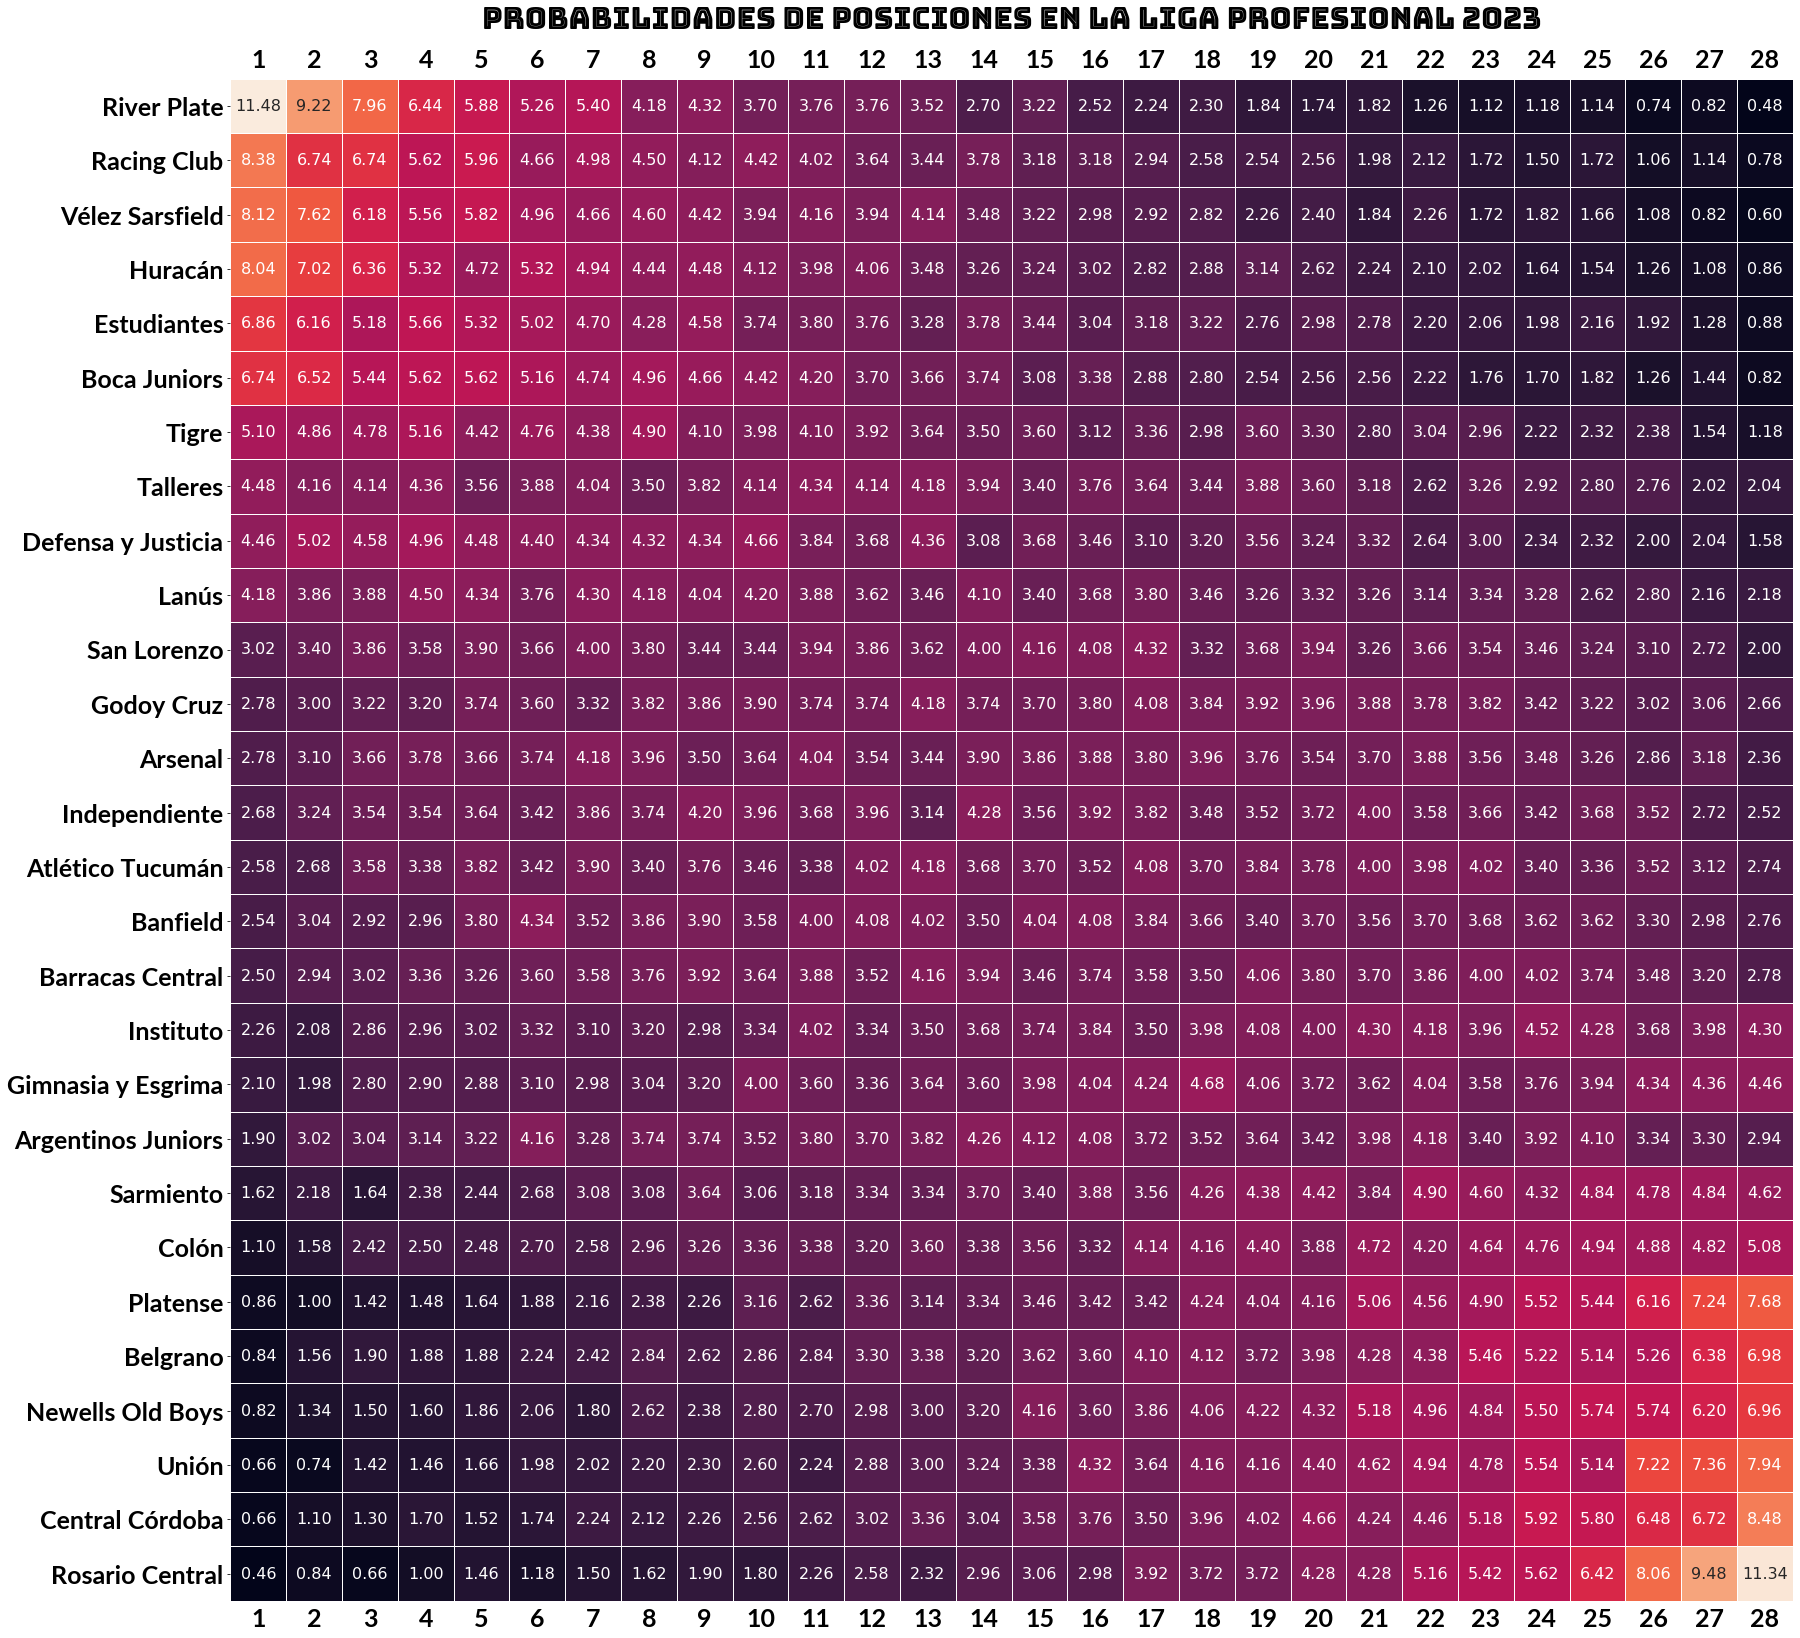

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(28,28))
sns.heatmap(placings.set_index('Equipos'), lw=1, annot=True, fmt=".2f", annot_kws = {'fontsize': 16}, cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.tick_params(axis='x', which='major', labelsize=20, labelbottom = True, bottom=False, top = False, labeltop=True)
plt.xticks(fontProperties=nexa.prop, size=25)
plt.yticks(fontProperties=nexa.prop, size=25)
plt.title('Probabilidades de posiciones en la Liga Profesional 2023', fontProperties=titulo.prop, size=30, pad=50)
plt.savefig('predicción torneo LPF2023.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
sns.

In [91]:
placings[[28, 0]].rename(columns={28:'Equipo', 0:'Probabilidad de salir 1º'}).sort_values(by='Probabilidad de salir 1º', ascending=False).reset_index(drop=True)

,Equipo,Probabilidad de salir 1º
0,[River Plate],11.7
1,[Racing Club],8.34
2,[Vélez Sarsfield],8.22
3,[Huracán],7.8
4,[Estudiantes],7.08
5,[Boca Juniors],6.98
6,[Tigre],5.22
7,[Defensa y Justicia],4.02
8,[Talleres],4.0
9,[Lanús],3.62


In [78]:
placings[0].reset_index().rename(columns={'28':'Equipos'})

,index,0
0,0,11.7
1,0,6.98
2,0,8.22
3,0,4.0
4,0,8.34
5,0,2.82
6,0,5.22
7,0,3.62
8,0,7.8
9,0,7.08


In [72]:
lista_elo_ratings_2

{'River Plate': 1654.700242886824,
 'Boca Juniors': 1613.29560192273,
 'Vélez Sarsfield': 1556.4573140771427,
 'Talleres': 1500.1169926122243,
 'Racing Club': 1556.8207756543943,
 'San Lorenzo': 1499.9882450946159,
 'Tigre': 1493.3034522035625,
 'Lanús': 1379.7747046859542,
 'Huracán': 1526.8868703731114,
 'Estudiantes': 1464.4879453335489,
 'Colón': 1395.3256672359917,
 'Defensa y Justicia': 1463.5470321287833,
 "Newell's Old Boys": 1467.6225508739356,
 'Argentinos Juniors': 1474.267580460928,
 'Banfield': 1385.7481070892209,
 'Rosario Central': 1433.1209177526407,
 'Atlético Tucumán': 1439.1743299846203,
 'Independiente': 1446.40103610061,
 'Godoy Cruz': 1376.6665390794801,
 'Unión': 1392.4016278404572,
 'Gimnasia y Esgrima': 1448.1058191629509,
 'Belgrano': 1326.877554865933,
 'Platense': 1370.2912787341181,
 'Sarmiento': 1386.3122353465862,
 'Central Córdoba': 1397.3939118755839,
 'Instituto': 1323.6118270662625,
 'Barracas Central': 1385.5133103070239,
 'Arsenal': 1401.78652925076